In [3]:
import sys

import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
import pickle as pickle
from sklearn import linear_model
import numpy.ma as ma
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing

import scipy as sp
import pandas as pd

import time

from copy import copy 

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# OS interaction
import os
import sys
import cftime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

import matplotlib.colors as mcolors

import glob
import dask
import dask.bag as db

from scipy import interpolate

import statsmodels.stats.multitest as multitest

from matplotlib.gridspec import GridSpec
from cartopy.crs import EqualEarth, PlateCarree

import calendar

In [4]:
data_in_path = '/glade/u/home/zcleveland/scratch/ERA5/dsw/' # path to subsetted data
sub_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/subsetting/' # path to subsetting scripts
plot_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/plotting/' # path to plotting scripts
fig_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/figures/' # path to generated figures
temp_scratch_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/temp/' # path to temp directory in scratch

In [5]:
# variable list to choose
var_list = [
    # 'lsp', # large scale precipitation (m of water) - accumu
    # 'cp', # convective precipitation (m of water) - accumu
    # 'tp', # total precipitation (m of water) - accumu -- DERIVED
    # 'sd', # snow depth  (m of water equivalent) - instan
    # 'msl', # mean sea level pressure (Pa) - instan
    # 'tcc', # total cloud cover (0-1) - instan
    # 'stl1', # soil temp layer 1 (K) - instan
    # 'stl2', # soil temp layer 2 (K) - instan
    # 'stl3', # soil temp layer 3 (K) - instan
    # 'stl4', # soil temp layer 4 (K) - instan
    # 'swvl1', # soil volume water content layer 1 (m^3 m^-3) - instan
    # 'swvl2', # soil volume water content layer 2 (m^3 m^-3) - instan
    # 'swvl3', # soil volume water content layer 3 (m^3 m^-3) - instan
    # 'swvl4', # soil volume water content layer 4 (m^3 m^-3) - instan
    # '2t', # 2 meter temp (K) - instan
    # '2d', # 2 meter dew point (K) - instan
    # 'ishf', # instant surface heat flux (W m^-2) - instan
    # 'ie', # instant moisture flux (kg m^-2 s^-1) - instan
    # 'sshf', # surface sensible heat flux (J m^-2) - accumu
    # 'slhf', # surface latent heat flux (J m^-2) - accumu
    # 'ssr', # surface net solar radiation (J m^-2) - accumu
    # 'str', # surface net thermal radiation (J m^-2) - accumu
    # 'sro', # surface runoff (m) - accumu
    # 'sf', # total snowfall (m of water equivalent) - accumu
    # 'cape', # convective available potential energy (J kg^-1) - instan
    'tcw', # total column water (kg m^-2) - sfc (sum total of solid, liquid, and vapor in a column)
]

In [83]:
def plot_onset_year(start_year, end_year=None):
    if end_year is None:
        end_year=start_year

    # open dataset and extract time frame
    ds = xr.open_dataset(os.path.join(data_in_path, 'NAM_onset.nc'))
    onset_time = ds['date'].sel(year=slice(str(start_year), str(end_year)))
    ds.close()

    # create array of ordinal day instead of date
    onset_day = onset_time.dt.dayofyear
    v_min = 120 #np.floor(onset_day.min().values/10)*10  # min value in data rounded down to 10
    v_max = 270 #np.ceil(onset_day.max().values/10)*10  # max value in data rounded up to 10
    
    # loop through years and plot
    for year in range(start_year, end_year+1):

        # set projection and subplot details
        projection = ccrs.PlateCarree()    
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

        # set levels and ticks for plotting
        levels = np.linspace(v_min, v_max, 100)
        # # last ordinal day of month
        # ticks = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
        # tick_strings = ['31 J', '59 F', '90 M', '120 A', '151 M', '181 J',
        #                '212 J', '243 A', '273 S', '304 O', '334 N', '365 D']

        # plot the data using contourf
        cf = ax.contourf(onset_day.longitude, onset_day.latitude,
                          onset_day.sel(year=str(year)).squeeze(drop=True),
                          cmap='turbo', levels=levels, vmin=v_min, vmax=v_max)    
        
        # add coastlines, state borders, and other features
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES)
    
        # add colorbar and ticks
        cbar = plt.colorbar(cf, ax=ax, label='Ordinal Day',
                           ticks=np.arange(v_min,v_max,10))
        
        # add title and others
        plt.title(f'First Day of the NAM\n{year}')
        # plt.savefig(f'{fig_out_path}onset/onset_day_{year}.png', dpi=300)
        plt.show()
        plt.close()

In [15]:
def plot_onset_trend(start_year, end_year):
    grad = xr.open_dataset(os.path.join(data_in_path, 'onset_gradient.nc'))['dayofyear']
    mean_grad = xr.open_dataset(os.path.join(data_in_path, 'onset_mean_gradient.nc'))['dayofyear']

    # set projection and subplot details
    projection = ccrs.PlateCarree()    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

    v_min = mean_grad.min()
    v_max = mean_grad.max()
    
    # set levels and ticks for plotting
    levels = np.linspace(v_min/4, v_max/4, 100)

    # plot the data using contourf
    cf = ax.contourf(mean_grad.longitude, mean_grad.latitude,
                      mean_grad, cmap='RdBu', levels=levels, vmin=v_min, vmax=v_max)    
    
    # add coastlines, state borders, and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES)

    # add colorbar and ticks
    cbar = plt.colorbar(cf, ax=ax)
    cbar.set_label(r'$\overline{\Delta\ d}$', rotation=90, labelpad=15)
    
    # add title and others
    plt.title(f'Average Change Onset Date of the NAM')
    # plt.savefig(f'{fig_out_path}onset/onset_mean_gradiant.png', dpi=300)
    plt.show()
    plt.close()
    


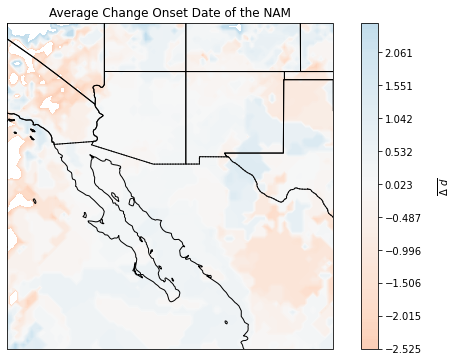

In [16]:
plot_onset_trend(1980,2019)